### Code that allows to evaluate the prediction performance of the 4 analysis variant determination tools, compared to the validation set generated for NA12878.

In [1]:
import pybedtools, os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import chain, combinations

In [2]:
#Functions for calculating performance metrics

def accuracy(TP,TN,FP,FN):
    # Exactitud (accuracy)
    ACC = round((TP+TN)/(TP+TN+FP+FN),3)
    return ACC

def precision(TP,FP):
    # Valor Predictivo Positivo (PPV) o Precisión
    ## probabilidad de presentar CNV si el resultado de es positivo.
    PPV = round(TP/(TP+FP),3)
    return PPV

def recall(TP,FN):
    # Recall, probability of detection, hit rate, power
    # Sensibilidad o Razón de Verdaderos Positivos (TPR) 
    ## Detecta realmente los casos positivos
    TPR = round(TP/(TP+FN), 3)
    return TPR

def FPR(FP,TN):
    # False positive rate, Razón de Falsos Positivos (FPR)
    FPR = round(FP/(FP+TN), 3)
    return FPR

def specificity(TN,FP):
    # Especificidad (SPC) o Razón de Verdaderos Negativos
    ##Detecta realmente los casos negativos
    TNR = round(TN/(FP+TN),3)
    return TNR

def FDR(FP,TP):
    # Ratio o Razón de Falsos Descubrimientos (FDR)
    FDR = round(FP/(FP+TP),3)
    return FDR

def Fscore(TP,FP,FN):
    #  F-measure is a measure of a test's accuracy
    ## The highest possible value of an F-score is 1.0, indicating perfect precision and recall
    F1 = round((TP / (TP + ((1/2)*(FP + FN)))), 3)
    return F1

def percentage(value, total):
    try:
        perc = round((value * 100)/total, 1)
    except ZeroDivisionError:
        perc = np.nan
    return perc

def try_except(a, b):
    try:
        return a.value_counts()[b]
    except KeyError: 
        return 0

def comb_list(list_tools):
    ensembl = []
    for lists in list_tools:
        t = list(lists)
        combi = chain.from_iterable(combinations(t, r) for r in range(len(t)+1) if r != 0) #el primer elemento es ('')
        ensembl.append([x for x in combi])
    return ensembl

def cnv_tools(combinations, dict_tool, a, b):
    if len(combinations[a][b]) == 1: #Solo hay una herramienta de detección de CNVs
        prediction = dict_tool[combinations[a][b][0]]
    else: #Hay más de una herramienta de detección de CNVs
        x = dict_tool[combinations[a][b][0]]
        y = x.cat(*(dict_tool[elem] for elem in list(combinations[a][b][1:])), postmerge=False).sort()
        prediction = y.merge(c=4, o="distinct") 
    return prediction

## METHOD 1
#### WEB + ICR
Metrics based on the number of EXONS taking into account the type of cnv identified.

In [5]:
def metrics_scoring_exon_type(inroi, roifile, intool, sample, svtool, out='.'):
    #Determine positive and negative exon regions
    roi = pd.read_csv(os.path.join(inroi, roifile), sep='\t', comment='#', header=None)
    roi_p = roi[roi.iloc[:,12].str.contains('positive')]
    roi_n = roi[roi.iloc[:,12].str.contains('negative')]
    
    # Create a BedTool object
    positives = pybedtools.BedTool.from_dataframe(roi_p)
    negatives = pybedtools.BedTool.from_dataframe(roi_n)
    
    #Calculate the total number of positive exons (match CNV) and negative exons (exons with probe without characterized CNV)
    P = (positives).count()
    N = (negatives).count()
    T=P+N
    
    #CNV type
    Pdel = try_except(roi_p.iloc[:,6],'deletion')
    Pdup = try_except(roi_p.iloc[:,6],'duplication')
    Pdel_dup = try_except(roi_p.iloc[:,6],'duplication|deletion')
    #CNV confidence score
    P00 = roi_p.iloc[:,7].value_counts()['0.0']
    P05 = roi_p.iloc[:,7].value_counts()['0.5']
    P10 = roi_p.iloc[:,7].value_counts()['1.0']
        
    #Create a dictionary, for each sample and each tool.
    #One of the dictionaries is for storing the confusion matrix information, and the other for the 
    #matrix-derived metrics.
    confusion_matrix_dict = {}   
    metrics_dict = {}
    
    tooldict={}
    for i in range(len(sample)):
        for cnvtool in range(len(sample[i])):
            tooldf = pd.read_csv(os.path.join(intool[i][0], sample[i][cnvtool]), sep='\t', comment='#', header=None)
            #Standardize the name of the type of variation
            tooldf.replace({'(?i)CNV loss':'deletion', '(?i)DEL':'deletion', 
                            '(?i)CNV gain':'duplication', '(?i)DUP':'duplication'}, 
                           regex=True, inplace=True)
            #Only the columns of interest are stored, to standardize the format of each tool: chromosome, start, 
            #end and type of predicted cnv.
            types=['deletion','duplication','duplication|deletion']
            indextype = tooldf.columns[tooldf.isin(types).any()]
            tool_df = pd.DataFrame().assign(chrom=tooldf[0],start=tooldf[1],end=tooldf[2],cnv_type_pred=tooldf[indextype])
            tooldict[sample[i][cnvtool]] = pybedtools.BedTool.from_dataframe(tool_df)
    
    #Determine all possible combinations for each tool by replicates.
    poss_comb = comb_list(sample)
    for i in range(len(poss_comb)):
        for n in range(len(poss_comb[i])):
            tool = cnv_tools(poss_comb, tooldict, i, n)
            tooldf2 = pybedtools.BedTool.to_dataframe(tool, names = ['chrom', 'start','end','cnv_type_pred'])
            #tooldf2.to_csv(os.path.join(out, "%s_.bed" % ('+'.join(comb_list(svtool)[i][n]))), sep='\t', index=False)

                        
            ##POSITIVE PREDICTED
            PP = (tool).count() 
            PPdel = try_except(tooldf2['cnv_type_pred'], 'deletion')
            PPdup = try_except(tooldf2['cnv_type_pred'], 'duplication')
            PPdup_del = try_except(tooldf2['cnv_type_pred'], 'duplication|deletion')



            ##TRUE POSITIVES 
            # BEDtools intersect -a GTp -b rep#_tool#
            exome_vs_tool = positives.intersect(tool, wa=True, wb=True)#.groupby(g=[1,2,3,4,7,8], c=17, o=["distinct"])
            TruePositive = pybedtools.BedTool.to_dataframe(exome_vs_tool, names = ['chrom', 'start','end','gene',
                                                                                   'transcript','exon','cnvtype',
                                                                                   'conf_score','match','probeid1',
                                                                                   'probeid2','probeid3','class',
                                                                                   'chrom_tool', 'start_tool','end_tool',
                                                                                   'cnv_type_pred'])

            TP = len(TruePositive[(TruePositive['cnvtype']==TruePositive['cnv_type_pred'])])+\
                 len(TruePositive[(TruePositive['cnvtype']=='duplication|deletion')])
            try:
                TPdel = (len(TruePositive[(TruePositive['cnvtype']=='deletion')&
                                                (TruePositive['cnv_type_pred']=='deletion')]))
            except KeyError:
                TPdel = 0
            try:
                TPdup = (len(TruePositive[(TruePositive['cnvtype']=='duplication')&
                                                (TruePositive['cnv_type_pred']=='duplication')]))
            except KeyError:
                TPdup=0
            try:
                TPdup_del = 0
                TPdup_del += len(TruePositive[(TruePositive['cnvtype']=='duplication|deletion')&
                                             (TruePositive['cnv_type_pred']=='duplication|deletion')])
                TPdup_del += len(TruePositive[(TruePositive['cnvtype']=='duplication|deletion')&
                                     (TruePositive['cnv_type_pred']=='deletion')]) +\
                             len(TruePositive[(TruePositive['cnvtype']=='duplication|deletion')&
                                     (TruePositive['cnv_type_pred']=='duplication')])
            except KeyError:
                TPdup_del = 0
                TPdup_del += len(TruePositive[(TruePositive['cnvtype']=='duplication|deletion')&
                                     (TruePositive['cnv_type_pred']=='deletion')]) +\
                    len(TruePositive[(TruePositive['cnvtype']=='duplication|deletion')&
                                     (TruePositive['cnv_type_pred']=='duplication')])
            TP_00 = try_except(TruePositive['conf_score'],0.0)
            TP_05 = try_except(TruePositive['conf_score'],0.5)
            TP_10 = try_except(TruePositive['conf_score'],1.0)


            ## FALSE POSITIVE 
            # BEDtools intersect -b GTexome -a rep#_tool# -v 
            FP = (tool - positives).count()
            FalsePositive = pybedtools.BedTool.to_dataframe((tool - positives), names = ['chrom', 'start','end',
                                                                                         'cnv_type_pred'])
            FPdel = try_except(FalsePositive['cnv_type_pred'],'deletion') 
            FPdup = try_except(FalsePositive['cnv_type_pred'],'duplication')
            FPdup_del = try_except(FalsePositive['cnv_type_pred'],'duplication|deletion')

            
            ##FALSE NEGATIVES 
            # BEDtools intersect -a GTp -b rep#_tool# -v
            FN = (positives - tool).count() + \
                len(TruePositive[(TruePositive['cnvtype'] != TruePositive['cnv_type_pred'])]) - \
                len(TruePositive[(TruePositive['cnvtype'] == 'duplication|deletion')])
            FalseNegative = pybedtools.BedTool.to_dataframe((positives - tool), names = ['chrom', 'start','end','gene',
                                                                                      'transcript','exon','cnvtype',
                                                                                      'conf_score','match','probeid1',
                                                                                      'probeid2','probeid3','class'])
            try:
                FNdel = (FalseNegative['cnvtype'].value_counts()['deletion']) + \
                               len(TruePositive[(TruePositive['cnvtype']=='deletion')&
                                                (TruePositive['cnv_type_pred']=='duplication')])
            except KeyError:
                FNdel = 0
            try:
                FNdup = (FalseNegative['cnvtype'].value_counts()['duplication']) + \
                               len(TruePositive[(TruePositive['cnvtype']=='duplication')&
                                                (TruePositive['cnv_type_pred']=='deletion')])
            except KeyError:
                FNdup = 0
            FNdup_del = try_except(FalseNegative['cnvtype'],'duplication|deletion')

            FN_00 = try_except(FalseNegative['conf_score'],0.0)
            FN_05 = try_except(FalseNegative['conf_score'],0.5)
            FN_10 = try_except(FalseNegative['conf_score'],1.0)


            ##TRUE NEGATIVES 
            TN = T-(TP+FP+FN)

            
            #The dictionary key is the name of the analysis tool or its combination.
            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])] = {}
            metrics_dict['+'.join(comb_list(svtool)[i][n])] = {}


            metrics_dict['+'.join(comb_list(svtool)[i][n])]['Overall'] = {'P':P,'N':N, 'PP':PP,'TP':TP,'TN':TN,'FP':FP,'FN':FN}
            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['Overall'] = {'P':str(P)+' ('+str(percentage(P,T))+'%)',
                                                                 'N':str(N)+' ('+str(percentage(N,T))+'%)', 
                                                                 'PP':str(PP)+' ('+str(percentage(PP,T))+'%)',
                                                                 'TP':str(TP),
                                                                 'TN':str(TN),
                                                                 'FP':str(FP),
                                                                 'FN':str(FN)}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['DEL'] = {'P':str(Pdel)+' ('+str(percentage(Pdel,P))+'%)',
                                                             'N':None,
                                                             'PP':str(PPdel)+' ('+str(percentage(PPdel, PP))+'%)',
                                                             'TP':str(TPdel)+' ('+str(percentage(TPdel, Pdel))+'%)',
                                                             'TN':None,
                                                             'FP':str(FPdel)+' ('+str(percentage(FPdel, PPdel))+'%)',
                                                             'FN':str(FNdel)+' ('+str(percentage(FNdel, Pdel))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['DUP'] = {'P':str(Pdup)+' ('+str(percentage(Pdup,P))+'%)',
                                                             'N':None,
                                                             'PP':str(PPdup)+' ('+str(percentage(PPdup, PP))+'%)',
                                                             'TP':str(TPdup)+' ('+str(percentage(TPdup, Pdup))+'%)',
                                                             'TN':None,
                                                             'FP':str(FPdup)+' ('+str(percentage(FPdup, PPdup))+'%)',
                                                             'FN':str(FNdup)+' ('+str(percentage(FNdup, Pdup))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['Indeterminate'] = {'P':str(Pdel_dup)+' ('+str(percentage(Pdel_dup,P))+'%)',
                                                                 'N':None,
                                                                 'PP':str(PPdup_del)+' ('+str(percentage(PPdup_del, PP))+'%)',
                                                                 'TP':str(TPdup_del)+' ('+str(percentage(TPdup_del, Pdel_dup))+'%)',
                                                                 'TN':None,
                                                                 'FP':str(FPdup_del)+' ('+str(percentage(FPdup_del, PPdup_del))+'%)',
                                                                 'FN':str(FNdup_del)+' ('+str(percentage(FNdup_del, Pdel_dup))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['CS_10'] = {'P':str(P10)+' ('+str(percentage(P10,P))+'%)',
                                                             'N':None,
                                                             'PP':None,
                                                             'TP':str(TP_10)+' ('+str(percentage(TP_10, P10))+'%)',
                                                             'TN':None,
                                                             'FP':None,
                                                             'FN':str(FN_10)+' ('+str(percentage(FN_10, P10))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['CS_05'] = {'P':str(P05)+' ('+str(percentage(P05,P))+'%)',
                                                             'N':None,
                                                             'PP':None,
                                                             'TP':str(TP_05)+' ('+str(percentage(TP_05, P05))+'%)',
                                                             'TN':None,
                                                             'FP':None,
                                                             'FN':str(FN_05)+' ('+str(percentage(FN_05, P05))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['CS_00'] = {'P':str(P00)+' ('+str(percentage(P00,P))+'%)',
                                                             'N':None,
                                                             'PP':None,
                                                             'TP':str(TP_00)+' ('+str(percentage(TP_00, P00))+'%)',
                                                             'TN':None,
                                                             'FP':None,
                                                             'FN':str(FN_00)+' ('+str(percentage(FN_00, P00))+'%)'}
        
    conf_mat = pd.DataFrame.from_dict({(i,j): confusion_matrix_dict[i][j]
                                       for i in confusion_matrix_dict.keys() 
                                       for j in confusion_matrix_dict[i].keys()},
                                      orient='index')

    met_mat = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j]
                                       for i in metrics_dict.keys() 
                                       for j in metrics_dict[i].keys()},
                                      orient='index')
    
    #Calculation of performance metrics from the calculated confusion matrix values
    met_mat['Accuracy'] = accuracy(met_mat['TP'], met_mat['TN'], met_mat['FP'], met_mat['FN'])
    met_mat['Precision']= precision(met_mat['TP'], met_mat['FP'])
    met_mat['Recall/Sensitivity'] = recall(met_mat['TP'], met_mat['FN'])
    met_mat['FPR'] = FPR(met_mat['FP'], met_mat['TN'])
    met_mat['Specificity'] = specificity(met_mat['TN'], met_mat['FP'])
    met_mat['FDR'] = FDR(met_mat['FP'], met_mat['TP'])
    met_mat['F1-score'] = Fscore(met_mat['TP'], met_mat['FP'], met_mat['FN'])
    
    ## Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(os.path.join(out,'metrics_ExonMethod1.xlsx'), engine='xlsxwriter')
    
    ## Write each dataframe to a different worksheet.
    met_mat.to_excel(writer, sheet_name='metrics')
    conf_mat.to_excel(writer, sheet_name='confusion_matrix')

    ## Close the Pandas Excel writer and output the Excel file.
    writer.save()
    
    
    
    #########################################################################
    
    ##PLOT PRECISION-SENSITIVITY SPACE
    
    reps = len(comb_list(svtool))
    tool_per_rep = [len(rep) for rep in comb_list(svtool)][0]
    
    prec=met_mat['Precision']
    tpr=met_mat['Recall/Sensitivity']
    sub_lists_tpr = np.array_split(tpr, reps)
    sub_lists_prec = np.array_split(prec, reps)

    names = np.array_split(['+'.join(name) for rep in comb_list(svtool) for name in rep],reps)
    colors = cm.rainbow(np.linspace(0, 1, tool_per_rep))
    ma = ['o','X','^','s']
    marks = [''.join(list((ma[0]*4,ma[1]*6,ma[2]*4,ma[3]))),''.join(list((ma[0]*4,ma[1]*6,ma[2]*4,ma[3])))]


    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Precisión-Sensibilidad', fontweight ="bold", fontsize=15, y=0.93)
    for rep, tool in enumerate(comb_list(svtool)):
        # add a new subplot iteratively
        ax = plt.subplot(2, 2, rep + 1)
        for x, y, c, n, m in zip(sub_lists_tpr[rep], sub_lists_prec[rep], colors, names[rep], marks[rep]):
            ax.scatter(x, y, color=c, label=n,marker=m)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True)
            ax.axis(xmin=0,xmax=1, ymin=0,ymax=1)
            ax.axhline(y = (P/(P+N)), color = 'r', linestyle = '--')
            ax.set_ylabel('Precisión')
            ax.set_xlabel('Sensibilidad')
    plt.savefig('exon_M1_PR.png')
    
    #----------------
    ##PLOT ROC SPACE
    
    tpr=met_mat['Recall/Sensitivity']
    fpr=met_mat['FPR']
    sub_lists_tpr = np.array_split(tpr, reps)
    sub_lists_fpr = np.array_split(fpr, reps)

    names = np.array_split(['+'.join(name) for rep in comb_list(svtool) for name in rep],reps)
    colors = cm.rainbow(np.linspace(0, 1, tool_per_rep))
    ma = ['o','X','^','s']
    marks = [''.join(list((ma[0]*4,ma[1]*6,ma[2]*4,ma[3]))),''.join(list((ma[0]*4,ma[1]*6,ma[2]*4,ma[3])))]


    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Espacio ROC (Receiver Operating Characteristic)', fontweight ="bold", fontsize=15, y=0.93)
    for rep, tool in enumerate(comb_list(svtool)):
        # add a new subplot iteratively
        ax = plt.subplot(2, 2, rep + 1)
        for x, y, c, n, m in zip(sub_lists_fpr[rep], sub_lists_tpr[rep], colors, names[rep], marks[rep]):
            ax.scatter(x, y, color=c, label=n,marker=m)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True)
            ax.plot([0, 1], [0, 1],'r--')
            ax.axis(xmin=0,xmax=0.27, ymin=0,ymax=0.27)
            ax.set_ylabel('TPR (True Positive Rate)')
            ax.set_xlabel('FPR (False Positive Rate)')
        
    plt.savefig('exon_M1_ROC.png')
    
    return met_mat, conf_mat.fillna('-')
    

,,P,N,PP,TP,TN,FP,FN,Accuracy,Precision,Recall/Sensitivity,FPR,Specificity,FDR,F1-score
XHMMrep1,Overall,1652,14305,337,79,14047,258,1573,0.885,0.234,0.048,0.018,0.982,0.766,0.079
DELLYrep1,Overall,1652,14305,29,8,14284,21,1644,0.896,0.276,0.005,0.001,0.999,0.724,0.010
CODEXrep1,Overall,1652,14305,245,27,14140,165,1625,0.888,0.141,0.016,0.012,0.988,0.859,0.029
LACONvrep1,Overall,1652,14305,247,32,14092,213,1620,0.885,0.131,0.019,0.015,0.985,0.869,0.034
XHMMrep1+DELLYrep1,Overall,1652,14305,366,87,14026,279,1565,0.884,0.238,0.053,0.020,0.980,0.762,0.086
XHMMrep1+CODEXrep1,Overall,1652,14305,525,74,13907,398,1578,0.876,0.157,0.045,0.028,0.972,0.843,0.070
XHMMrep1+LACONvrep1,Overall,1652,14305,556,102,13853,452,1550,0.875,0.184,0.062,0.032,0.968,0.816,0.092
DELLYrep1+CODEXrep1,Overall,1652,14305,274,35,14119,186,1617,0.887,0.158,0.021,0.013,0.987,0.842,0.037
DELLYrep1+LACONvrep1,Overall,1652,14305,275,39,14071,234,1613,0.884,0.143,0.024,0.016,0.984,0.857,0.041
CODEXrep1+LACONvrep1,Overall,1652,14305,482,55,13933,372,1597,0.877,0.129,0.033,0.026,0.974,0.871,0.053


P  \
XHMMrep1                                Overall        1652 (10.4%)   
                                        DEL             408 (24.7%)   
                                        DUP            1032 (62.5%)   
                                        Indeterminate   212 (12.8%)   
                                        CS_10             67 (4.1%)   
...                                                             ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP            1032 (62.5%)   
                                        Indeterminate   212 (12.8%)   
                                        CS_10             67 (4.1%)   
                                        CS_05           186 (11.3%)   
                                        CS_00          1399 (84.7%)   

                                                                   N  \
XHMMrep1                                Overall        14305 (89.6%)   
                                        DEL                        -   
                                        DUP                        -   
                                        Indeterminate              -   
                                        CS_10                      -   
...                                                              ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP                        -   
                                        Indeterminate              -   
                                        CS_10                      -   
                                        CS_05                      -   
                                        CS_00                      -   

                                                                PP  \
XHMMrep1                                Overall         337 (2.1%)   
                                        DEL            266 (78.9%)   
                                        DUP             71 (21.1%)   
                                        Indeterminate     0 (0.0%)   
                                        CS_10                    -   
...                                                            ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP            310 (47.0%)   
                                        Indeterminate     0 (0.0%)   
                                        CS_10                    -   
                                        CS_05                    -   
                                        CS_00                    -   

                                                               TP     TN  \
XHMMrep1                                Overall                79  14047   
                                        DEL             40 (9.8%)      -   
                                        DUP             37 (3.6%)      -   
                                        Indeterminate    2 (0.9%)      -   
                                        CS_10          45 (67.2%)      -   
...                                                           ...    ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP             16 (1.6%)      -   
                                        Indeterminate   15 (7.1%)      -   
                                        CS_10          34 (50.7%)      -   
                                        CS_05           10 (5.4%)      -   
                                        CS_00           91 (6.5%)      -   

                                                                FP  \
XHMMrep1                                Overall                258   
                                        DEL            224 (84.2%)   
                                        DUP             34 (47.9%)   
                                        Indeterminate     0 (nan%)   
                                        CS_10                    -   
...                                                            ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP            259 (83.5%)   
                                  

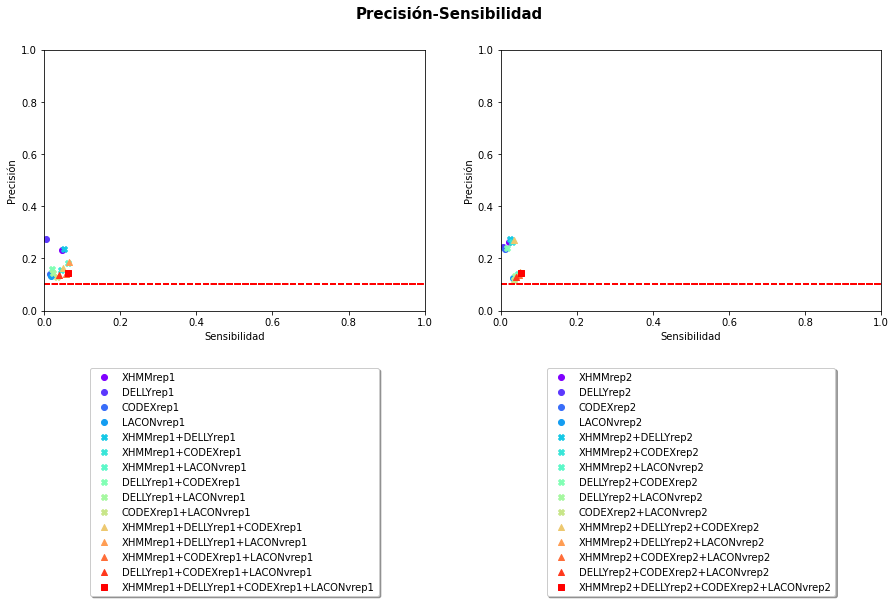

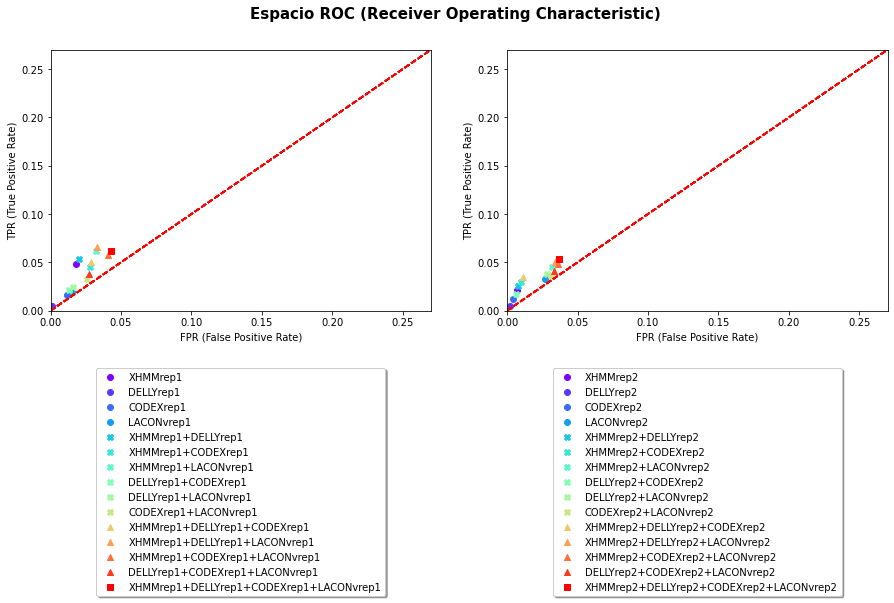

In [6]:
a,b=metrics_scoring_exon_type(inroi="roi_indet_highrestrict", roifile="ROI.bed",
                              intool=[['./NGS_rep2_tools'],['./NGS_rep1_tools']],
                              sample=[['NGS25906-HiSeq4000-exoma-Run200604-HG-0001_S287_align.realign.recal_xhmm_cnv.bed',
                                       'NGS25906-HiSeq4000-exoma-Run200604-HG-0001_S287_HQ_delly_exon_filt5.bed',
                                       'NGS25906-HiSeq4000-exoma-Run200604-HG-0001_S287.cnv_exon_CODEX.bed',
                                       'NGS25906-HiSeq4000-exoma-Run200604-HG-0001_S287.cnv_LACONv.bed'],
                                     ['NGS25603-HiSeq4000-exoma-Run200513-HG-0001_S358_align.realign.recal_XHMM_cnv.bed',
                                       'NGS25603-HiSeq4000-exoma-Run200513-HG-0001_S358_HQ_delly_exon.bed',
                                       'NGS25603-HiSeq4000-exoma-Run200513-HG-0001_S358.cnv_exon_CODEX.bed',
                                       'NGS25603-HiSeq4000-exoma-Run200513-HG-0001_S358.cnv_LACONv.bed']],
                              svtool=[['XHMMrep1','DELLYrep1','CODEXrep1','LACONvrep1'],
                                      ['XHMMrep2','DELLYrep2','CODEXrep2','LACONvrep2']])

display(a,b)

## METHOD 2
#### WEB + ICR
Metrics based on the number of exons covered by the gold standard reference CNV. The type of CNV is also taken into account. 

In [1]:
def metrics_scoring_exoncnv_type(ingt, GTexome, inroi, roifile, intool, sample, svtool, out='.'):    
    #Determine positive and negative exon regions
    roi = pd.read_csv(os.path.join(inroi, roifile), sep='\t', comment='#', header=None)
    roi_p = roi[roi.iloc[:,12].str.contains('positive')]
    roi_n = roi[roi.iloc[:,12].str.contains('negative')]
    
    # Create a BedTool object
    positives = pybedtools.BedTool.from_dataframe(roi_p)
    negatives = pybedtools.BedTool.from_dataframe(roi_n)
    GT = pybedtools.BedTool(os.path.join(ingt,GTexome))
    
    #Calculate the total number of positive exons (match CNV) and negative exons (exons with probe without characterized CNV)
    P = (positives).count()
    N = (negatives).count()  
    T = P+N
    
    #CNV type
    Pdel = try_except(roi_p.iloc[:,6],'deletion')
    Pdup = try_except(roi_p.iloc[:,6],'duplication')
    Pdel_dup = try_except(roi_p.iloc[:,6],'duplication|deletion')
    #CNV confidence score
    P00 = roi_p.iloc[:,7].value_counts()['0.0']
    P05 = roi_p.iloc[:,7].value_counts()['0.5']
    P10 = roi_p.iloc[:,7].value_counts()['1.0']

    #Create a dictionary, for each sample and each tool.
    #One of the dictionaries is for storing the confusion matrix information, and the other for the 
    #matrix-derived metrics.
    confusion_matrix_dict = {}   
    metrics_dict = {}
    
    tooldict={}
    for i in range(len(sample)):
        for cnvtool in range(len(sample[i])):
            tooldf = pd.read_csv(os.path.join(intool[i][0], sample[i][cnvtool]), sep='\t', comment='#', header=None)
            #Standardize the name of the type of variation
            tooldf.replace({'(?i)CNV loss':'deletion', '(?i)DEL':'deletion', 
                            '(?i)CNV gain':'duplication', '(?i)DUP':'duplication'}, 
                           regex=True, inplace=True)
            #Only the columns of interest are stored, to standardize the format of each tool: chromosome, start, 
            #end and type of predicted cnv.
            types=['deletion','duplication','duplication|deletion']
            indextype = tooldf.columns[tooldf.isin(types).any()]
            tool_df = pd.DataFrame().assign(chrom=tooldf[0],start=tooldf[1],end=tooldf[2],cnv_type_pred=tooldf[indextype])
            tooldict[sample[i][cnvtool]] = pybedtools.BedTool.from_dataframe(tool_df)
    
    #Determine all possible combinations for each tool by replicates   
    poss_comb = comb_list(sample)
    for i in range(len(poss_comb)):
        for n in range(len(poss_comb[i])):
            tool = cnv_tools(poss_comb, tooldict, i, n)
            tooldf2 = pybedtools.BedTool.to_dataframe(tool, names = ['chrom', 'start','end','cnv_type_pred'])
                
         
            ##POSITIVE PREDICTED
            tool_vs_exome_ = tool.intersect(GT, wao=True).groupby(g=[4,8,20,26], c=[1,2,3], o=["distinct"],full=True)
            #fields: chrom,startex1,endex1,cnvtypepred,startcnv,endcnv,typecnv,cs,countex,startsex,endsex,
            tool_vs_exome = [(f[0],f[1],f[2],f[3],f[5],f[6],f[7],f[19],f[25],f[28],f[29]) for f in tool_vs_exome_]

            PP = 0
            PPdel = 0
            PPdup = 0
            PPdup_del = 0
            for x in tool_vs_exome:
                #if count_exon (x[8]) is '.' it means that there is only 1 exon identified by the tool that does 
                #not overlap with the gold standard (but is positive predicted by the tool, i.e. false positive). 
                #If there is a number, it means that it overlaps with the gold standard, so we are left with the 
                #number of total exons that match that CNV of the gold standard (not with the exons that form only 
                #identified by the tool).
                PP += int(x[8]) if x[8].isnumeric() == True else len(x[9].split(','))

                PPdel += int(x[8]) if x[8].isnumeric() == True and x[3]=='deletion' \
                                    else (len(x[9].split(',')) if x[8].isnumeric() == False and x[3]=='deletion' else 0)

                PPdup += int(x[8]) if x[8].isnumeric() == True and x[3]=='duplication' \
                                    else (len(x[9].split(',')) if x[8].isnumeric() == False and x[3]=='duplication' else 0)
                try:
                    PPdup_del += int(x[8]) if x[8].isnumeric() == True and x[3]=='duplication|deletion' \
                                    else (len(x[9].split(',')) if x[8].isnumeric() == False and x[3]=='duplication|deletion'
                                          else 0)
                except KeyError:
                    PPdup_del = 0


            ##TRUE POSITIVES
            # BEDtools intersect -a GTexome -b rep#_tool#
            exome_vs_tool = GT.intersect(tool, wa=True, wb=True).groupby(g=[1,2,3,4,16,22,26], c=[24,25], o=["distinct"])
            TruePositive = pybedtools.BedTool.to_dataframe(exome_vs_tool, names = ['chrom', 'start','end','cnvtype',
                                                                                   'conf_score','count_exon',
                                                                                   'cnv_type_pred','start_tool',
                                                                                   'end_tool'])

            TP = (TruePositive.count_exon[(TruePositive['cnvtype']==TruePositive['cnv_type_pred'])]).sum()+ \
                 (TruePositive.count_exon[(TruePositive['cnvtype']=='duplication|deletion')]).sum()

            TPdel = (TruePositive.count_exon[(TruePositive['cnvtype']=='deletion')&(TruePositive['cnv_type_pred']=='deletion')]).sum()
            TPdup = (TruePositive.count_exon[(TruePositive['cnvtype']=='duplication')&(TruePositive['cnv_type_pred']=='duplication')]).sum()

            try:
                TPdup_del = 0
                TPdup_del += (TruePositive.count_exon[(TruePositive['cnvtype']=='duplication|deletion')&
                                                      (TruePositive['cnv_type_pred']=='duplication|deletion')]).sum()
                TPdup_del += (TruePositive.count_exon[(TruePositive['cnvtype']=='duplication|deletion')&
                                                      (TruePositive['cnv_type_pred']=='deletion')]).sum() +\
                             (TruePositive.count_exon[(TruePositive['cnvtype']=='duplication|deletion')&
                                                      (TruePositive['cnv_type_pred']=='duplication')]).sum()
            except KeyError:
                TPdup_del = 0
                TPdup_del += (TruePositive.count_exon[(TruePositive['cnvtype']=='duplication|deletion')&
                                                      (TruePositive['cnv_type_pred']=='deletion')]).sum() +\
                             (TruePositive.count_exon[(TruePositive['cnvtype']=='duplication|deletion')&
                                                      (TruePositive['cnv_type_pred']=='duplication')]).sum()

            TP_00 = try_except(TruePositive['conf_score'],0.0)
            TP_05 = try_except(TruePositive['conf_score'],0.5)
            TP_10 = try_except(TruePositive['conf_score'],1.0)


            ##FALSE POSITIVE
            # BEDtools intersect -b GTexome -a rep#_tool# -v 
            FP = (tool - GT).count() 
            FalsePositive = pybedtools.BedTool.to_dataframe((tool - GT), names=['chrom','start','end','cnv_type_pred'])
            FPdel = try_except(FalsePositive['cnv_type_pred'],'deletion') 
            FPdup = try_except(FalsePositive['cnv_type_pred'],'duplication')
            FPdup_del = try_except(FalsePositive['cnv_type_pred'],'duplication|deletion')


            ##FALSE NEGATIVE
            # BEDtools intersect -a GTexome -b rep#_tool# -v
            exome_vs_tool_V = GT.intersect(tool, v=True).groupby(g=[1,2,3,4,16], c=22, o=["distinct"])
            FalseNegative = pybedtools.BedTool.to_dataframe(exome_vs_tool_V, names = ['#chrom','start','end','cnv_type',
                                                                                      'conf_score','count_exon'])
            FN = (FalseNegative.count_exon).sum() + \
                 (TruePositive.count_exon[(TruePositive['cnvtype']!=TruePositive['cnv_type_pred'])]).sum() - \
                 (TruePositive.count_exon[(TruePositive['cnvtype']=='duplication|deletion')]).sum()


            FNdel = (FalseNegative.count_exon[FalseNegative['cnv_type'].str.contains('^deletion$')]).sum() + \
                    (TruePositive.count_exon[(TruePositive['cnvtype']=='deletion')&
                                             (TruePositive['cnv_type_pred']=='duplication')]).sum()

            FNdup = (FalseNegative.count_exon[FalseNegative['cnv_type'].str.contains('^duplication$')]).sum() + \
                    (TruePositive.count_exon[(TruePositive['cnvtype']=='duplication')&
                                             (TruePositive['cnv_type_pred']=='deletion')]).sum()
            try:
                FNdup_del = (FalseNegative.count_exon[FalseNegative['cnv_type'].str.contains('duplication\|deletion')]).sum()
            except KeyError:
                FNdup_del = 0

            FN_00 = try_except(FalseNegative['conf_score'],0.0)
            FN_05 = try_except(FalseNegative['conf_score'],0.5)
            FN_10 = try_except(FalseNegative['conf_score'],1.0)


            ##TRUE NEGATIVE 
            TN = T-(TP+FP+FN)
        
        
            #The dictionary key is the name of the analysis tool or its combination.
            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])] = {}
            metrics_dict['+'.join(comb_list(svtool)[i][n])] = {}
            


            metrics_dict['+'.join(comb_list(svtool)[i][n])]['Overall'] = {'P':P,'N':N, 'PP':PP,'TP':TP,'TN':TN,'FP':FP,'FN':FN}
            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['Overall'] = {'P':str(P)+' ('+str(percentage(P,T))+'%)',
                                                                 'N':str(N)+' ('+str(percentage(N,T))+'%)', 
                                                                 'PP':str(PP)+' ('+str(percentage(PP,T))+'%)',
                                                                 'TP':str(TP),
                                                                 'TN':str(TN),
                                                                 'FP':str(FP),
                                                                 'FN':str(FN)}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['DEL'] = {'P':str(Pdel)+' ('+str(percentage(Pdel,P))+'%)',
                                                             'N':None,
                                                             'PP':str(PPdel)+' ('+str(percentage(PPdel, PP))+'%)',
                                                             'TP':str(TPdel)+' ('+str(percentage(TPdel, Pdel))+'%)',
                                                             'TN':None,
                                                             'FP':str(FPdel)+' ('+str(percentage(FPdel, PPdel))+'%)',
                                                             'FN':str(FNdel)+' ('+str(percentage(FNdel, Pdel))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['DUP'] = {'P':str(Pdup)+' ('+str(percentage(Pdup,P))+'%)',
                                                             'N':None,
                                                             'PP':str(PPdup)+' ('+str(percentage(PPdup, PP))+'%)',
                                                             'TP':str(TPdup)+' ('+str(percentage(TPdup, Pdup))+'%)',
                                                             'TN':None,
                                                             'FP':str(FPdup)+' ('+str(percentage(FPdup, PPdup))+'%)',
                                                             'FN':str(FNdup)+' ('+str(percentage(FNdup, Pdup))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['Indeterminate'] = {'P':str(Pdel_dup)+' ('+str(percentage(Pdel_dup,P))+'%)',
                                                                 'N':None,
                                                                 'PP':str(PPdup_del)+' ('+str(percentage(PPdup_del, PP))+'%)',
                                                                 'TP':str(TPdup_del)+' ('+str(percentage(TPdup_del, Pdel_dup))+'%)',
                                                                 'TN':None,
                                                                 'FP':str(FPdup_del)+' ('+str(percentage(FPdup_del, PPdup_del))+'%)',
                                                                 'FN':str(FNdup_del)+' ('+str(percentage(FNdup_del, Pdel_dup))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['CS_10'] = {'P':str(P10)+' ('+str(percentage(P10,P))+'%)',
                                                             'N':None,
                                                             'PP':None,
                                                             'TP':str(TP_10)+' ('+str(percentage(TP_10, P10))+'%)',
                                                             'TN':None,
                                                             'FP':None,
                                                             'FN':str(FN_10)+' ('+str(percentage(FN_10, P10))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['CS_05'] = {'P':str(P05)+' ('+str(percentage(P05,P))+'%)',
                                                             'N':None,
                                                             'PP':None,
                                                             'TP':str(TP_05)+' ('+str(percentage(TP_05, P05))+'%)',
                                                             'TN':None,
                                                             'FP':None,
                                                             'FN':str(FN_05)+' ('+str(percentage(FN_05, P05))+'%)'}

            confusion_matrix_dict['+'.join(comb_list(svtool)[i][n])]['CS_00'] = {'P':str(P00)+' ('+str(percentage(P00,P))+'%)',
                                                             'N':None,
                                                             'PP':None,
                                                             'TP':str(TP_00)+' ('+str(percentage(TP_00, P00))+'%)',
                                                             'TN':None,
                                                             'FP':None,
                                                             'FN':str(FN_00)+' ('+str(percentage(FN_00, P00))+'%)'}
        
    conf_mat = pd.DataFrame.from_dict({(i,j): confusion_matrix_dict[i][j]
                                       for i in confusion_matrix_dict.keys() 
                                       for j in confusion_matrix_dict[i].keys()},
                                      orient='index')

    met_mat = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j]
                                       for i in metrics_dict.keys() 
                                       for j in metrics_dict[i].keys()},
                                      orient='index')
    
    
    #Calculation of performance metrics from the calculated confusion matrix values 
    met_mat['Accuracy'] = accuracy(met_mat['TP'], met_mat['TN'], met_mat['FP'], met_mat['FN'])
    met_mat['Precision']= precision(met_mat['TP'], met_mat['FP'])
    met_mat['Recall/Sensitivity'] = recall(met_mat['TP'], met_mat['FN'])
    met_mat['FPR'] = FPR(met_mat['FP'], met_mat['TN'])
    met_mat['Specificity'] = specificity(met_mat['TN'], met_mat['FP'])
    met_mat['FDR'] = FDR(met_mat['FP'], met_mat['TP'])
    met_mat['F1-score'] = Fscore(met_mat['TP'], met_mat['FP'], met_mat['FN'])

    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(os.path.join(out,'metrics_exonCNVmethod2.xlsx'), engine='xlsxwriter')
    
    # Write each dataframe to a different worksheet.
    met_mat.to_excel(writer, sheet_name='metrics')
    conf_mat.to_excel(writer, sheet_name='confusion_matrix')

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    
    
    
    #########################################################################
    
    
        ##PLOT PRECISION-SENSITIVITY SPACE
    reps = len(comb_list(svtool))
    tool_per_rep = [len(rep) for rep in comb_list(svtool)][0]

    prec=met_mat['Precision']
    tpr=met_mat['Recall/Sensitivity']
    sub_lists_tpr = np.array_split(tpr, reps)
    sub_lists_prec = np.array_split(prec, reps)

    names = np.array_split(['+'.join(name) for rep in comb_list(svtool) for name in rep],reps)
    colors = cm.rainbow(np.linspace(0, 1, tool_per_rep))
    ma = ['o','X','^','s']
    marks = [''.join(list((ma[0]*4,ma[1]*6,ma[2]*4,ma[3]))),''.join(list((ma[0]*4,ma[1]*6,ma[2]*4,ma[3])))]


    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Espacio Precision-Sensibilidad', fontweight ="bold", fontsize=15, y=0.93)
    for rep, tool in enumerate(comb_list(svtool)):
        # add a new subplot iteratively
        ax = plt.subplot(2, 2, rep + 1)
        for x, y, c, n, m in zip(sub_lists_tpr[rep], sub_lists_prec[rep], colors, names[rep], marks[rep]):
            ax.scatter(x, y, color=c, label=n,marker=m)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True)
            ax.axis(xmin=0,xmax=1, ymin=0,ymax=1)
            ax.axhline(y = (P/(P+N)), color = 'r', linestyle = '--')
            ax.set_ylabel('Precisión')
            ax.set_xlabel('Sensibilidad')
    plt.savefig('exon_M2_PR.png')
    
    
        #----------------
    ##PLOT ROC SPACE
    
    tpr=met_mat['Recall/Sensitivity']
    fpr=met_mat['FPR']
    sub_lists_tpr = np.array_split(tpr, reps)
    sub_lists_fpr = np.array_split(fpr, reps)

    names = np.array_split(['+'.join(name) for rep in comb_list(svtool) for name in rep],reps)
    colors = cm.rainbow(np.linspace(0, 1, tool_per_rep))
    ma = ['o','X','^','s']
    marks = [''.join(list((ma[0]*4,ma[1]*6,ma[2]*4,ma[3]))),''.join(list((ma[0]*4,ma[1]*6,ma[2]*4,ma[3])))]


    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Espacio ROC (Receiver Operating Characteristic)', fontweight ="bold", fontsize=15, y=0.93)
    for rep, tool in enumerate(comb_list(svtool)):
        # add a new subplot iteratively
        ax = plt.subplot(2, 2, rep + 1)
        for x, y, c, n, m in zip(sub_lists_fpr[rep], sub_lists_tpr[rep], colors, names[rep], marks[rep]):
            ax.scatter(x, y, color=c, label=n,marker=m)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True)
            ax.plot([0, 1], [0, 1],'r--')
            ax.axis(xmin=0,xmax=0.27, ymin=0,ymax=0.27)
            ax.set_ylabel('TPR (True Positive Rate)')
            ax.set_xlabel('FPR (False Positive Rate)')
        
    plt.savefig('exon_M2_ROC.png')
    
    
    return met_mat, conf_mat.fillna('-')

,,P,N,PP,TP,TN,FP,FN,Accuracy,Precision,Recall/Sensitivity,FPR,Specificity,FDR,F1-score
XHMMrep1,Overall,1652,14305,348,130,14087,218,1522,0.891,0.374,0.079,0.015,0.985,0.626,0.130
DELLYrep1,Overall,1652,14305,34,13,14284,21,1639,0.896,0.382,0.008,0.001,0.999,0.618,0.015
CODEXrep1,Overall,1652,14305,264,32,14140,165,1620,0.888,0.162,0.019,0.012,0.988,0.838,0.035
LACONvrep1,Overall,1652,14305,583,324,14036,213,1384,0.900,0.603,0.190,0.015,0.985,0.397,0.289
XHMMrep1+DELLYrep1,Overall,1652,14305,382,143,14066,239,1509,0.890,0.374,0.087,0.017,0.983,0.626,0.141
XHMMrep1+CODEXrep1,Overall,1652,14305,544,126,13947,358,1526,0.882,0.260,0.076,0.025,0.975,0.740,0.118
XHMMrep1+LACONvrep1,Overall,1652,14305,852,394,13837,412,1314,0.892,0.489,0.231,0.029,0.971,0.511,0.313
DELLYrep1+CODEXrep1,Overall,1652,14305,298,45,14119,186,1607,0.888,0.195,0.027,0.013,0.987,0.805,0.048
DELLYrep1+LACONvrep1,Overall,1652,14305,616,336,14015,234,1372,0.899,0.589,0.197,0.016,0.984,0.411,0.295
CODEXrep1+LACONvrep1,Overall,1652,14305,829,344,13877,372,1364,0.891,0.480,0.201,0.026,0.974,0.520,0.284


P  \
XHMMrep1                                Overall        1652 (10.4%)   
                                        DEL             408 (24.7%)   
                                        DUP            1032 (62.5%)   
                                        Indeterminate   212 (12.8%)   
                                        CS_10             67 (4.1%)   
...                                                             ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP            1032 (62.5%)   
                                        Indeterminate   212 (12.8%)   
                                        CS_10             67 (4.1%)   
                                        CS_05           186 (11.3%)   
                                        CS_00          1399 (84.7%)   

                                                                   N  \
XHMMrep1                                Overall        14305 (89.6%)   
                                        DEL                        -   
                                        DUP                        -   
                                        Indeterminate              -   
                                        CS_10                      -   
...                                                              ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP                        -   
                                        Indeterminate              -   
                                        CS_10                      -   
                                        CS_05                      -   
                                        CS_00                      -   

                                                                PP  \
XHMMrep1                                Overall         348 (2.2%)   
                                        DEL            257 (73.9%)   
                                        DUP             91 (26.1%)   
                                        Indeterminate     0 (0.0%)   
                                        CS_10                    -   
...                                                            ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP            460 (42.8%)   
                                        Indeterminate     0 (0.0%)   
                                        CS_10                    -   
                                        CS_05                    -   
                                        CS_00                    -   

                                                                TP     TN  \
XHMMrep1                                Overall                130  14087   
                                        DEL             51 (12.5%)      -   
                                        DUP              57 (5.5%)      -   
                                        Indeterminate   22 (10.4%)      -   
                                        CS_10             5 (7.5%)      -   
...                                                            ...    ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP            122 (11.8%)      -   
                                        Indeterminate  141 (66.5%)      -   
                                        CS_10            8 (11.9%)      -   
                                        CS_05             6 (3.2%)      -   
                                        CS_00            29 (2.1%)      -   

                                                                FP  \
XHMMrep1                                Overall                218   
                                        DEL            184 (71.6%)   
                                        DUP             34 (37.4%)   
                                        Indeterminate     0 (nan%)   
                                        CS_10                    -   
...                                                            ...   
XHMMrep2+DELLYrep2+CODEXrep2+LACONvrep2 DUP            259 (56.3%)   
                      

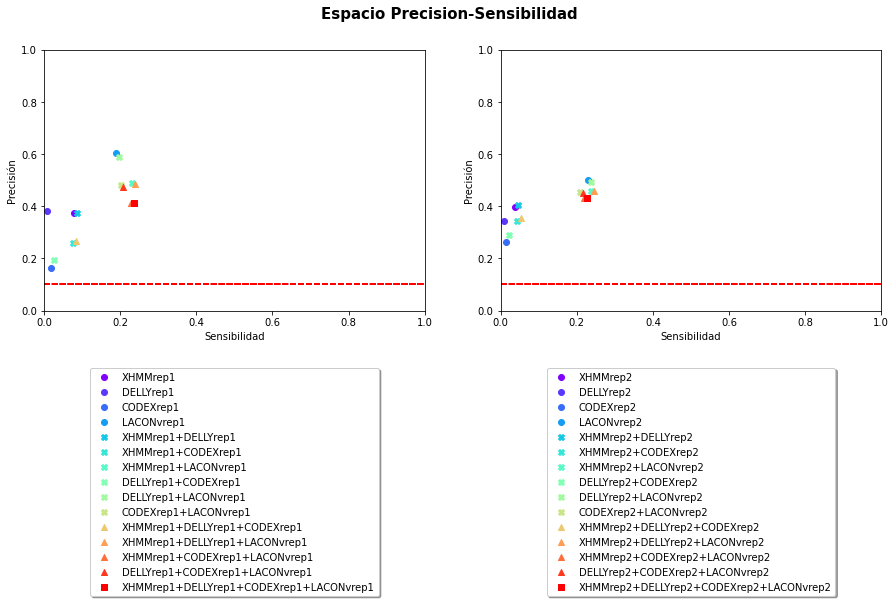

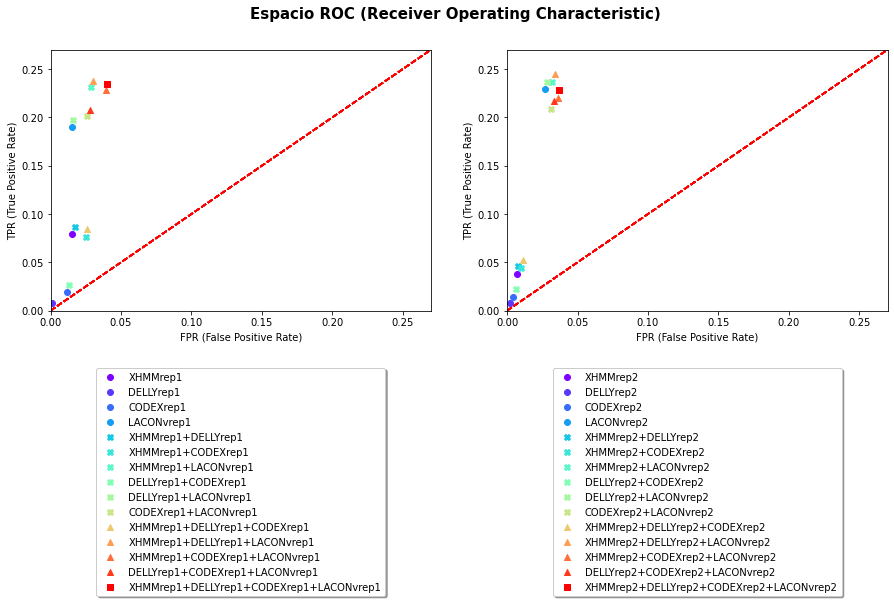

In [6]:
a,b=metrics_scoring_exoncnv_type(ingt='.', GTexome="ground_truth_exome_indet.bed", 
                                 inroi="roi_indet_highrestrict", roifile="ROI.bed", 
                                 intool=[['./NGS_rep2_tools'],['./NGS_rep1_tools']],
                                 sample=[['NGS25906-HiSeq4000-exoma-Run200604-HG-0001_S287_align.realign.recal_xhmm_cnv.bed',
                                       'NGS25906-HiSeq4000-exoma-Run200604-HG-0001_S287_HQ_delly_exon_filt5.bed',
                                       'NGS25906-HiSeq4000-exoma-Run200604-HG-0001_S287.cnv_exon_CODEX.bed',
                                       'NGS25906-HiSeq4000-exoma-Run200604-HG-0001_S287.cnv_LACONv.bed'],
                                        ['NGS25603-HiSeq4000-exoma-Run200513-HG-0001_S358_align.realign.recal_XHMM_cnv.bed',
                                       'NGS25603-HiSeq4000-exoma-Run200513-HG-0001_S358_HQ_delly_exon.bed',
                                       'NGS25603-HiSeq4000-exoma-Run200513-HG-0001_S358.cnv_exon_CODEX.bed',
                                       'NGS25603-HiSeq4000-exoma-Run200513-HG-0001_S358.cnv_LACONv.bed']],
                              svtool=[['XHMMrep1','DELLYrep1','CODEXrep1','LACONvrep1'],
                                      ['XHMMrep2','DELLYrep2','CODEXrep2','LACONvrep2']])

display(a,b)